# Seed Segmentation 

In [ ]:
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.image_segmentation.git --quiet

  Preparing metadata (setup.py) ... done


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.losses import CategoricalCrossentropy

from gcpds.image_segmentation.datasets.segmentation import TomatoSeeds

from gcpds.image_segmentation.models.baseline_unet import unet_baseline

from gcpds.image_segmentation.losses import DiceCoefficient
from gcpds.image_segmentation.losses import GeneralizedCrossEntropy

from gcpds.image_segmentation.metrics import DiceCoefficientMetric

In [ ]:
dataset = TomatoSeeds(split=[0.001,0.1])
train,val, *_ = dataset()

def preprocess(img,mask):
    img = tf.image.resize(img,(256,256))
    mask = tf.image.resize(mask,(256,256))#Ch 1: Seed, Ch 2: No germinate, Ch 3: germinate
    mask = tf.cast(mask>0, tf.float32)
    mask = mask[...,1:]
    back_ground = tf.reduce_sum(mask, axis =[-1], keepdims=True)
    back_ground = back_ground == 0
    back_ground = tf.cast(back_ground, tf.float32)
    mask = tf.concat([mask,back_ground], axis=-1) #Ch 1: No germinate, Ch 2: germinate, Ch 3: Background
    return img,mask

train = train.map(lambda x,y,id:preprocess(x,y))
train = train.batch(1)
train = train.cache()
val = val.map(lambda x,y,id:preprocess(x,y))
val = val.batch(1)
val = val.cache()

Downloading...
From: https://drive.google.com/uc?id=1J-jjASPC0VtibEj1_2MJ_lnhuP_ltvgY&confirm=t
To: /usr/local/lib/python3.9/dist-packages/gcpds/image_segmentation/datasets/segmentation/Datasets/tomatoSeeds/TomatoSeeds.zip
100%|██████████| 236M/236M [00:01<00:00, 212MB/s]


 Number of images for Partition 1: 85


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


 Number of images for Partition 2: 10
 Number of images for Partition 3: 1


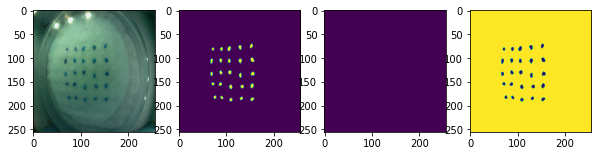

In [ ]:
fig, axes = plt.subplots(1,4, figsize=(10,5))
for x,y in train.take(1):
    axes[0].imshow(x[0])
    axes[1].imshow(y[0,...,0])
    axes[2].imshow(y[0,...,1])
    axes[3].imshow(y[0,...,2])

plt.show()

In [ ]:
model = unet_baseline(input_shape=(256,256,3), out_channels=3, out_ActFunction='softmax')
model.compile(loss=DiceCoefficient(), optimizer='RMSprop', metrics=[DiceCoefficientMetric(name='dice_no_germinate',target_class=0),
                                                                 DiceCoefficientMetric(name='dice_germinate',target_class=1)
                                                                 ])
model.fit(train,validation_data=val, epochs=100)

Epoch 1/100
85/85 [==============================] - 11s 25ms/step - loss: -0.3329 - dice_no_germinate: -0.1939 - dice_germinate: -0.0101 - val_loss: -0.3250 - val_dice_no_germinate: -0.0177 - val_dice_germinate: -0.0073
Epoch 2/100
85/85 [==============================] - 2s 20ms/step - loss: -0.4478 - dice_no_germinate: -0.4670 - dice_germinate: -0.0145 - val_loss: -0.3334 - val_dice_no_germinate: -0.0061 - val_dice_germinate: -0.0054
Epoch 3/100
85/85 [==============================] - 2s 23ms/step - loss: -0.5354 - dice_no_germinate: -0.6969 - dice_germinate: -0.0189 - val_loss: -0.3392 - val_dice_no_germinate: -0.0023 - val_dice_germinate: -0.0239
Epoch 4/100
85/85 [==============================] - 2s 19ms/step - loss: -0.5813 - dice_no_germinate: -0.7990 - dice_germinate: -0.0260 - val_loss: -0.3420 - val_dice_no_germinate: -0.0024 - val_dice_germinate: -0.0318
Epoch 5/100
85/85 [==============================] - 2s 19ms/step - loss: -0.6059 - dice_no_germinate: -0.8199 - dice_g

In [ ]:
model = unet_baseline(input_shape=(256,256,3), out_channels=3, out_ActFunction='softmax')
model.compile(loss=CategoricalCrossentropy(), optimizer='RMSprop', metrics=[
                                                                 DiceCoefficientMetric(name='dice_no_germinate',target_class=0),
                                                                 DiceCoefficientMetric(name='dice_germinate',target_class=1)])
model.fit(train,validation_data=val, epochs=100)

Epoch 1/100
85/85 [==============================] - 11s 25ms/step - loss: 0.7980 - dice_no_germinate: -0.0718 - dice_germinate: -0.0064 - val_loss: 0.4345 - val_dice_no_germinate: -0.0215 - val_dice_germinate: -0.0085
Epoch 2/100
85/85 [==============================] - 2s 18ms/step - loss: 0.4186 - dice_no_germinate: -0.1157 - dice_germinate: -0.0111 - val_loss: 0.2203 - val_dice_no_germinate: -0.0221 - val_dice_germinate: -0.0094
Epoch 3/100
85/85 [==============================] - 2s 18ms/step - loss: 0.1896 - dice_no_germinate: -0.2132 - dice_germinate: -0.0248 - val_loss: 0.1164 - val_dice_no_germinate: -0.0395 - val_dice_germinate: -0.0093
Epoch 4/100
85/85 [==============================] - 2s 18ms/step - loss: 0.0771 - dice_no_germinate: -0.3983 - dice_germinate: -0.0590 - val_loss: 0.0601 - val_dice_no_germinate: -0.2855 - val_dice_germinate: -0.0291
Epoch 5/100
85/85 [==============================] - 2s 18ms/step - loss: 0.0334 - dice_no_germinate: -0.6182 - dice_germinate:

In [ ]:
model = unet_baseline(input_shape=(256,256,3), out_channels=3, out_ActFunction='softmax')
model.compile(loss=GeneralizedCrossEntropy(0.01), optimizer='RMSprop',
                                                        metrics=[DiceCoefficientMetric(name='dice_no_germinate',target_class=0),
                                                                 DiceCoefficientMetric(name='dice_germinate',target_class=1)
                                                                 ])
model.fit(train,validation_data=val, epochs=100)

Epoch 1/100
85/85 [==============================] - 25s 54ms/step - loss: 1.5888 - dice_no_germinate: -0.0724 - dice_germinate: -0.0065 - val_loss: 1.1107 - val_dice_no_germinate: -0.0221 - val_dice_germinate: -0.0087
Epoch 2/100
85/85 [==============================] - 2s 21ms/step - loss: 0.8341 - dice_no_germinate: -0.1173 - dice_germinate: -0.0115 - val_loss: 0.4813 - val_dice_no_germinate: -0.0221 - val_dice_germinate: -0.0087
Epoch 3/100
85/85 [==============================] - 2s 27ms/step - loss: 0.3772 - dice_no_germinate: -0.2167 - dice_germinate: -0.0268 - val_loss: 0.2192 - val_dice_no_germinate: -0.0275 - val_dice_germinate: -0.0118
Epoch 4/100
85/85 [==============================] - 2s 19ms/step - loss: 0.1520 - dice_no_germinate: -0.4069 - dice_germinate: -0.0633 - val_loss: 0.1220 - val_dice_no_germinate: -0.1765 - val_dice_germinate: -0.0596
Epoch 5/100
85/85 [==============================] - 2s 19ms/step - loss: 0.0647 - dice_no_germinate: -0.6296 - dice_germinate: